[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/113_sd_scratch_2/113_sd_scratch_2.ipynb)

# Stable Diffusion desde cero - Parte 2

En el post anterior vimos una introducción a los modelos de difusión, implementando Stable Diffusion desde cero para generación de imágenes. Sin embargo las imágenes generadas por el modelo eran aleatorias, si bien se parecen a imágenes del dataset MNIST (el cual usamos para entrenar el modelo). En este post vamos a mejorar nuestra implementación añadiendo la capacidad de controlar la imagen generada, de la misma forma que con Stable Diffusion podemos describir el contenido de la imagen mediante texto.

![](https://images.squarespace-cdn.com/content/v1/628be1d26f9ad648b2e202b1/43a38f92-eb67-4218-8789-55250e4b8827/txt2img.png)

Seguimos usando el mismo dataset.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np


# mnist = fetch_openml('mnist_784', version=1)
# # importante que las imágenes estén en el rango -1, 1
# X, y = 2. * (mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255.) - 1., mnist["target"].values.astype(int)
# np.savez_compressed("mnist.npz", X=X, y=y)

# la descarga puede tardar un rato, así que te recomiendo comentar las líneas anteriores después 
# de ejecutarlas la primera vez y descomentar las siguientes para cargar los datos desde el disco

X, y = np.load("mnist.npz")["X"], np.load("mnist.npz")["y"]

X.shape, y.shape

((70000, 28, 28), (70000,))

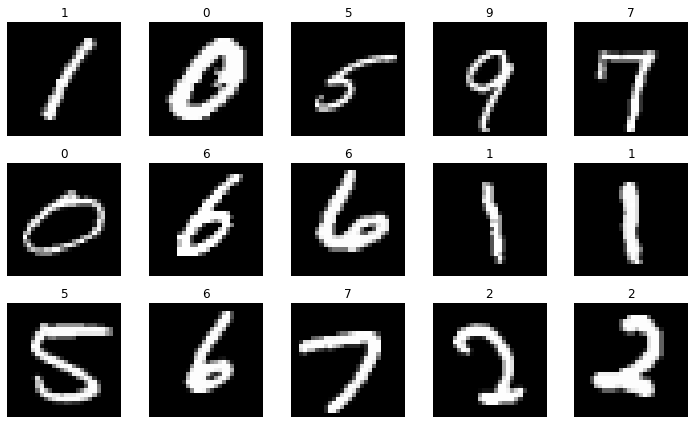

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow(X[ix], cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

## Añadiendo información sobre la imagen a generar

Lo más sencillo que podemos hacer si queremos controlar el comportamiento de nuestro modelo para generar la imagen que queramos es añadir la etiqueta de la que disponemos. Para ello usaremos la misma aproximación que vimos en el post anterior para añadir al modelo información sobre el `step` del `noise scheduler`. En nuestro caso, introduciremos la etiqueta en formato `one-hot encoding`, la proyectaremos a la misma dimensión que el embedding del `step` y los sumaremos.

In [6]:
from unet import UNet, SinusoidalPositionEmbeddings
import math
import torch

class ConditionalDiffusionModel(torch.nn.Module):
	def __init__(self, embed_dim=32):
		super().__init__()
		self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
		self.label_embed = torch.nn.Linear(10, embed_dim)
		self.unet = UNet(in_ch=1 + embed_dim, n_classes=1)

	def forward(self, x, t, y):
		B, C, H, W = x.shape
		t = self.time_embed(t)
		t = t[:, :, None, None].repeat(1, 1, H, W)
		y = torch.nn.functional.one_hot(y, 10).float()
		y = self.label_embed(y)
		y = y[:, :, None, None].repeat(1, 1, H, W)
		t = t + y
		x = torch.cat((x, t), dim=1)
		return self.unet(x)

model = ConditionalDiffusionModel()
output = model(torch.randn(10, 1, 28, 28), torch.randint(0, 1000, (10,)), torch.randint(0, 10, (10,)))
output.shape

torch.Size([10, 1, 28, 28])

A este modelo se le llama `Conditional` ya que está *condicionado* por la información extra que le pasamos (en este caso la etiqueta de la imagen).

## Entrenamiento del modelo

Pues con este simple cambio ya tenemos nuestro modelo listo para entrenar. Primero, vamos a actualizar nuestro Dataset.

In [7]:
import numpy as np 

def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0)
	return betas, alphas, alphas_hat

class Dataset(torch.utils.data.Dataset):
	def __init__(self, X, y, T=1000):
		self.X = X
		self.y = y
		self.T = T
		self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, ix):
		im = torch.from_numpy(self.X[ix]) # imagen original
		t = torch.randint(0, self.T, (1,))
		noise = torch.randn_like(im) # ruido
		x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
		return x.unsqueeze(0).float(), noise.unsqueeze(0).float(), t, self.y[ix]

Y ya podemos entrenar el modelo

In [9]:
import tqdm

EPOCHS = 10
BATCH_SIZE = 32

ds = Dataset(X, y) 
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = ConditionalDiffusionModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
	losses = []
	pb = tqdm.tqdm(dl)
	for im, noise, t, y in pb:
		im, noise, t, y = im.cuda(), noise.cuda(), t.cuda().squeeze(-1), y.cuda()
		output = model(im, t, y)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

  0%|          | 0/2188 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/juan/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/juan/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/juan/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_198756/3542234047.py", line 24, in __getitem__
    return x.unsqueeze(0).float(), noise.unsqueeze(0).float(), t, self.y[ix]
RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
